# Neural Image Style Transfer


## Introduction

**Neural Image Style Transfer** is a way to transfer style (texture, color, etc) from one image called as **Style Image** on to the primary image called as **content image** using Convolutional Neural Network algorithm in machine learning. To achieve this, this project makes use of transfer learning approach wherein the most relevant parts or layers of a pre-trained sophisticated machine learning model are used. Specifically, this project makes use of VGG-19, a convolutional neural network that is 19 layers deep.

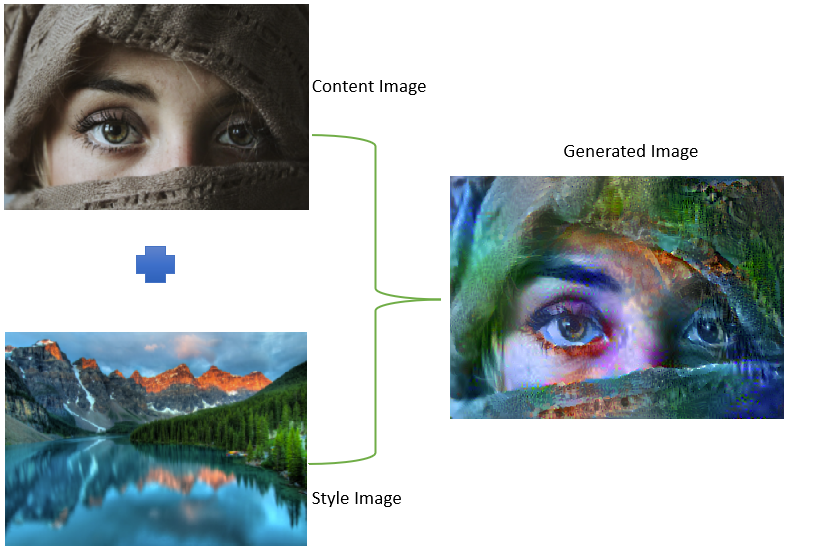

## More about VGG-19

**VGG-19** is a convolutional neural network consisting of 19 layers (16 convolutional layers and 3 fully connected layers, 5 MaxPooling layers and 1 SoftMax layer. It was trained on the ImageNet database that contains about a million images of 1000 categories.

VGG-19 can recognize low-level features using earlier layers and high-level features using deep layers. 

#### **VGG-19 Architecture**
##### (conv means convolution, FC means fully connected)
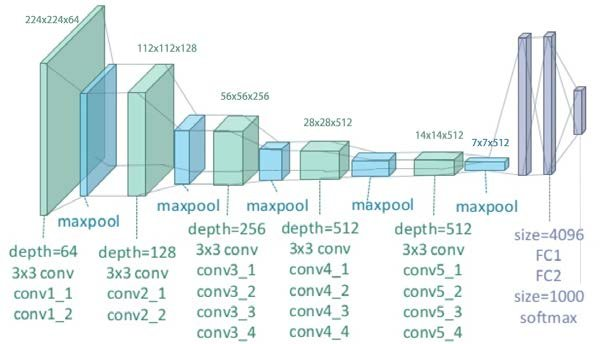

image source: [researchgate.net](https://www.researchgate.net/figure/llustration-of-the-network-architecture-of-VGG-19-model-conv-means-convolution-FC-means_fig2_325137356)

#### **Image representations in a  Convolutional Neural Network**
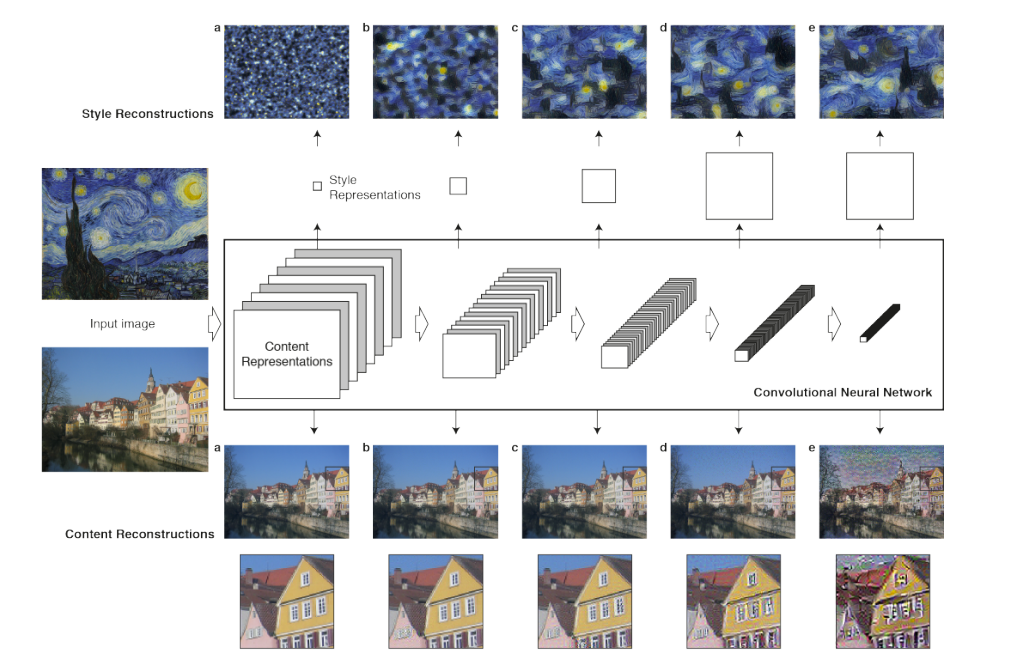
Image Source: [arxiv.org](https://arxiv.org/pdf/1508.06576.pdf)

## Transfer Learning Approach

Transfer learning is a method of using pre-trained model usually trained over a very large amount of data wherein the model of an already existing model is used on a different but related problem. VGG-199 is one such model which is trained on high end GPUs for weeks. Developing and training such a model every time which takes such an amount of time and resources is not a feasible way to go about solving a custom machine learning problem. 

From the computer vision perspective, the earlier layers of a neural network are where the edges are detected, shapes in the middle layers while more task-specific features in the later layers. So in transfer learning with pre-trained model, we take just the earlier and middle layers.

## Steps Involved in Neural Image Style Transfer

1.   Compute the features for each of the images (content, style and generated image)
2.   Compute content loss and style loss
3.   Compute total combined loss
4.   Backpropagate the gradient to update the generated image weight pixels.



## Code Implementation

### Import and configure the required modules

In [ ]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [ ]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

##### Let us define a function tensor_to_image to convert the input tensor to an image format. 

In [ ]:
def tensor_to_image(tensor):
  # Make the pixel values from [0 , 1] to [0, 255]
  tensor = tensor*255

  #Convert the pixels from float type to int type.
  tensor = np.array(tensor, dtype=np.uint8)

  # Get the first item(the image with 3 channels) if the tensor shape is greater than 3. 
  # In our case, the input tensor will be 4, where the first dimension is always 1. 
  # It is so because some of the functions we are using will be expecting the input tensors to be of size 4, 
  # for processing purposes.
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

#### In neural style transfer, we use 3 images:


1.   Content Image (the image on which the style is to be applied)
2.   Style Image (the style is used from this image)
3.   Generated Image (the final image which blends the style of the style image onto the content image)


#### Let's download images and choose a style image and a content image:

In [ ]:
content_path = tf.keras.utils.get_file('','https://i.ibb.co/0c8cWHk/content-pexels-noelle-otto-906052.jpg')
style_path = tf.keras.utils.get_file('','https://i.ibb.co/nkpSQh6/style-pexels-james-wheeler-417074.jpg')

245584/245584 [==============================] - 1s 5us/step


## Visualize the input

Define a function to load an image and limit its maximum dimension to 512 pixels.

In [ ]:
def load_img(path_to_img):
  # Set max_dim to 512 to set the maximum dimensions of the input image.
  max_dim = 512

  # Read the image from the given path
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)

  # Convert the image pixels to float32
  img = tf.image.convert_image_dtype(img, tf.float32)

  # Convert all the dimensions - except the 
  # last dimension - of the img to float32 data type
  shape = tf.cast(tf.shape(img)[:-1], tf.float32)

  # Get the maximum dimension long_dim from the shape of the input image.
  long_dim = max(shape)

  # get the scale measure so that the scale could be used to resize the image
  scale = max_dim / long_dim

  # casts a tensor to a new type
  new_shape = tf.cast(shape * scale, tf.int32)

  # resize the image based on the new_shape integer result
  img = tf.image.resize(img, new_shape)

  # increase the dimension of the existing array by one more dimension.
  img = img[tf.newaxis, :]
  return img

Create a simple function to display an image:

In [ ]:
# define a function to reuse to be able to display the images
def imshow(image, title=None):
  # removes dimensions of size 1 from the shape of a tensor
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

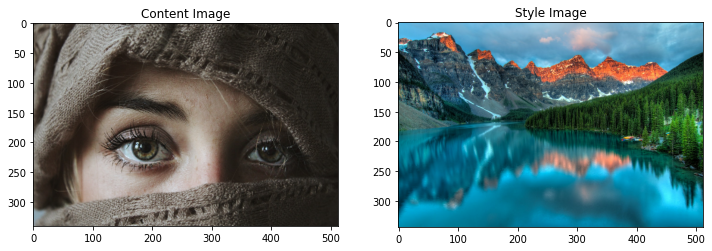

In [ ]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

#### The generated image will be having the style image (nature image) applied on the human portrait image.

## Define content and style representations


Load a [VGG19](https://keras.io/api/applications/vgg/#vgg19-function) without classification head

In [ ]:
# instantiate the VGG19 architecture
# 1.  set include_top = False to exclude the 3 fully connected layers
#     at the top of the network.
# 2.  use weights='imagenet' to use reuse the weights 
#     that were pre-trained on the ImageNet
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')


80134624/80134624 [==============================] - 1s 0us/step


Now list the layer names

In [ ]:
print('VGG19 Layer Names:\n')
# print all the VGG-19 layer names
for layer in vgg.layers:
  print(layer.name)

VGG19 Layer Names:

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


Choose intermediate layers from the network to represent the style and content of the image:


In [ ]:
# use the second layer of the final block for content image
# as it is trained deep enough to capture objects and arrangements
# in the input image
content_layers = ['block5_conv2'] 

# use first conv layer of each block.
# the first layers usually detect simple features like diagonal lines,
# first layer edges, some common patterns, etc
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

## Build the model 

The networks in `tf.keras.applications` are designed so you can easily extract the intermediate layer values using the Keras functional API.

To define a model using the functional API, specify the inputs and outputs:

`model = Model(inputs, outputs)`

This following function builds a VGG19 model that returns a list of intermediate layer outputs:

In [ ]:
def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on ImageNet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

And to create the model:

In [ ]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 344, 512, 64)
  min:  0.0
  max:  841.45917
  mean:  25.344889

block2_conv1
  shape:  (1, 172, 256, 128)
  min:  0.0
  max:  4002.3774
  mean:  134.37303

block3_conv1
  shape:  (1, 86, 128, 256)
  min:  0.0
  max:  9637.794
  mean:  131.53984

block4_conv1
  shape:  (1, 43, 64, 512)
  min:  0.0
  max:  18249.818
  mean:  546.02496

block5_conv1
  shape:  (1, 21, 32, 512)
  min:  0.0
  max:  3191.0874
  mean:  47.034523



### Cost Function

In style transfer, the weights and biases of the neural net are kept constant while the target image is updated by changing the pixel values. This process takes place until the cost function has the minimum loss. 




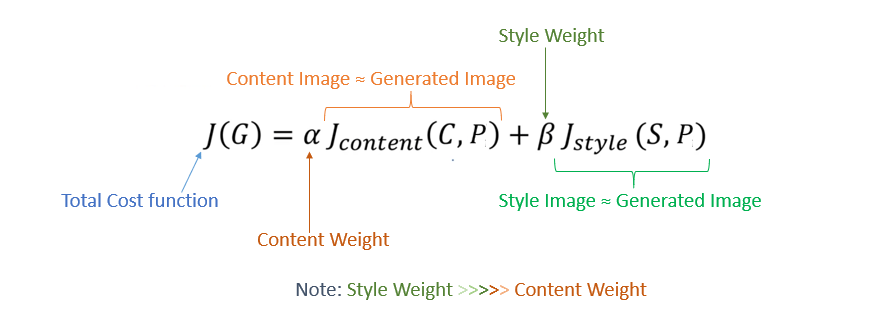

Image Source: [DeepLearning.ai](https://www.deeplearning.ai/)

### Calculating Content Loss

We can check how similar the generated image and the content images are by measuring how far (different) are the features of the content and the generated images.

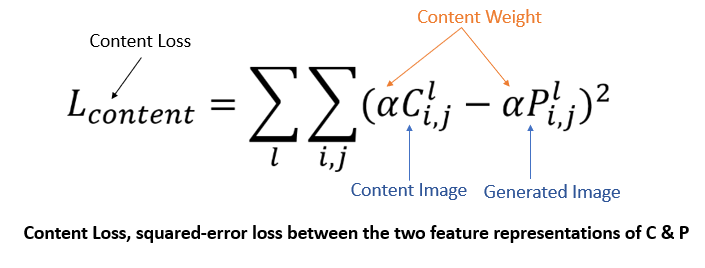

image source: [DeepLearning.ai](https://deeplearning.ai)

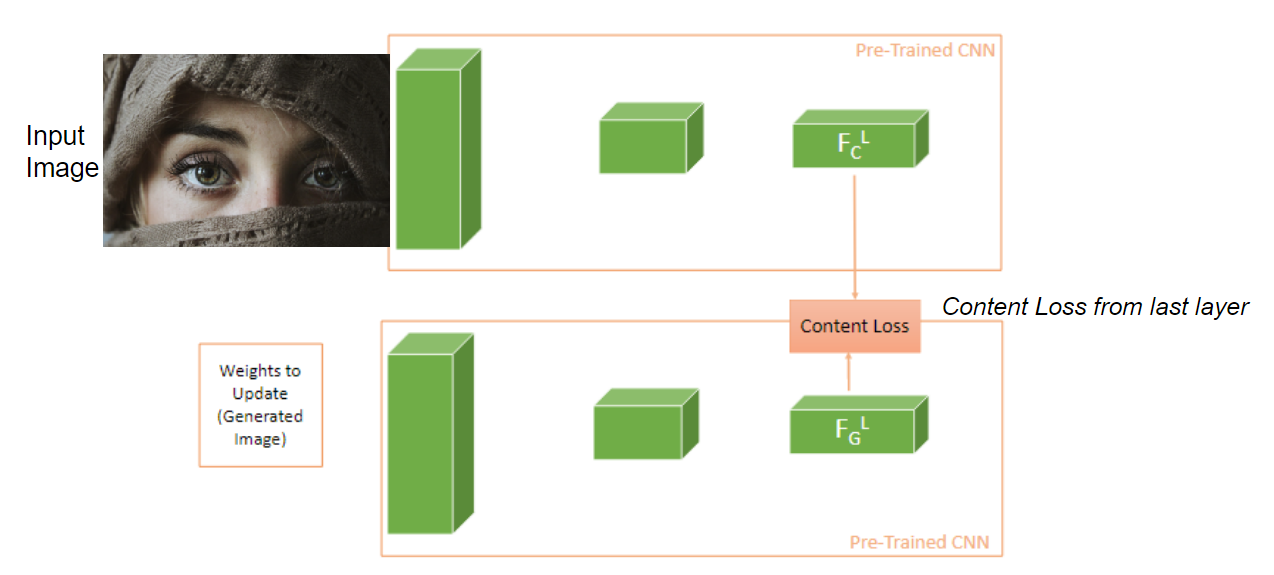

### Calculating Style Loss

Using style loss, we can check how much style related details of the style image are in the generated image. To achieve that, the similar correlation of the activations between the style image and the generated image are measured by correlation matrix called as gram matrix.

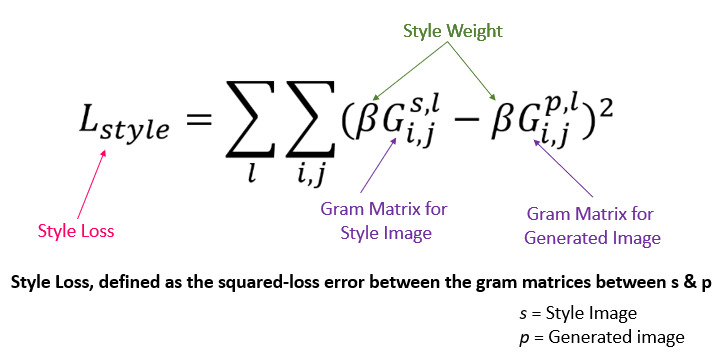

Image Source: [DeepLearning.ai](https://deeplearning.ai)

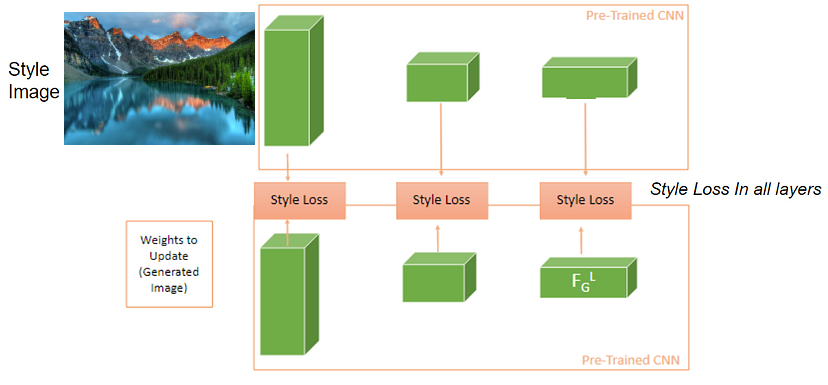

**Gram matrix** only takes into account whether the style related features are present in the image weights, textures and shapes. The gram matrix is a dot product of feature maps of a layer that summarizes the activations that co-occur.

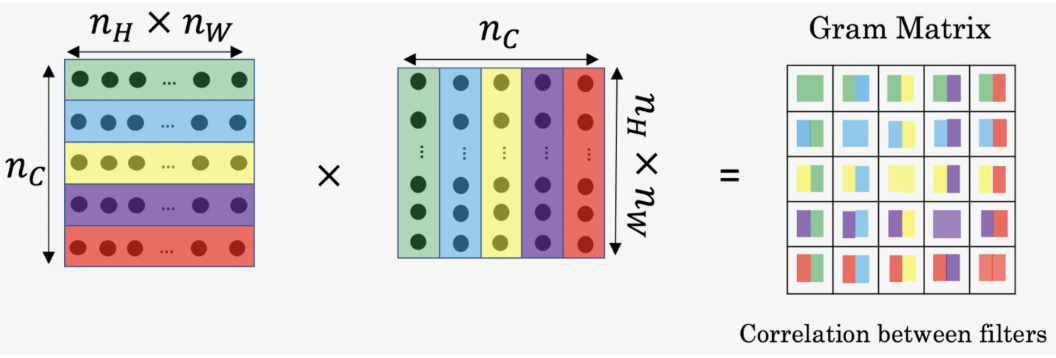

Image Source: [DeepLearning.ai](https://deeplearning.ai)

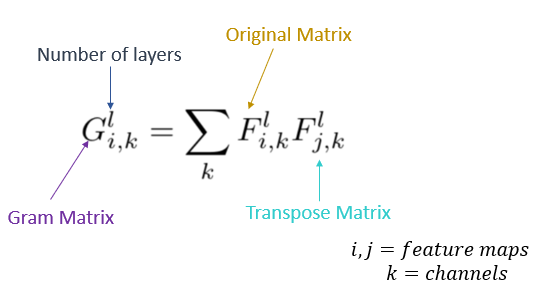

Image Source: [DeepLearning.ai](https://deeplearning.ai)

Gram matrix helps find how similar the original matrix is with the transpose matrix and if the dot product is large it implies that it is highly similar.

### Calculating Total Loss

The total loss is calculated as weighted loss of content and style losses. The α and β are used to control how much amount of content and style are to be represented in the generated image. The main goal of total loss calculation is to minimize the total loss so that the generated image is as close with respect to the content from the content image and with respect to the style from the style image.

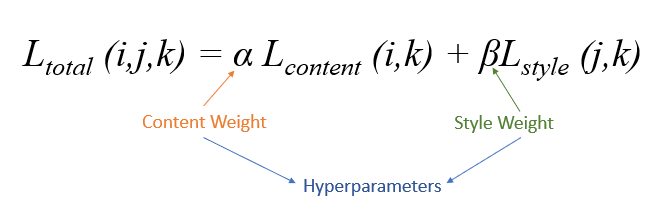

Image Source: [DeepLearning.ai](https://deeplearning.ai)

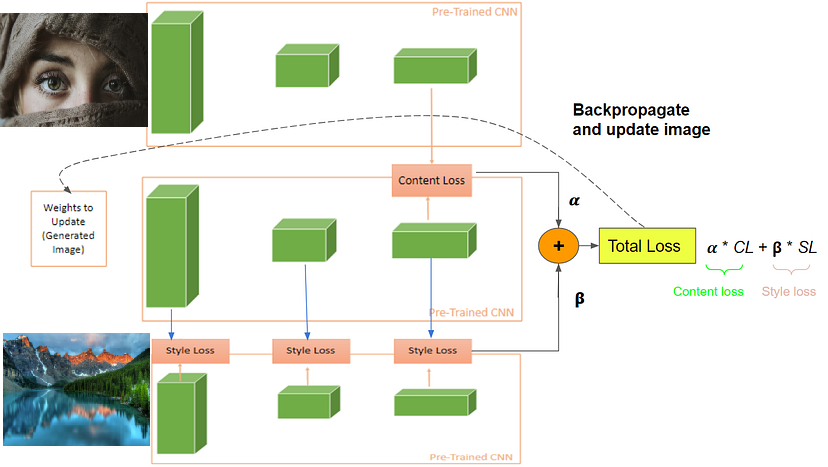

## Calculate style

Defining the **gram_matrix** function and pass the **input_tensor** to calculate the gram matrix of given input tensor.


In [ ]:
def gram_matrix(input_tensor):
  # einsum function is used to evaluate the einstein summation convention
  # on the operands.
  # the first argument uses the classical einstein summation subscripts.
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)

  # cast the tensor to a new type, float32 in this case
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

## Extract style and content


Build a model that returns the style and content tensors.

In [ ]:
# custom implementation of the StyleContentModel
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    # inherit the StyleContentModel from the parent class
    super(StyleContentModel, self).__init__()

    # set the model with the style and content layers
    self.vgg = vgg_layers(style_layers + content_layers)

    # define the layers fo style and content extraction in our custom model
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)

    # set trainable to false as we want to use the same VGG-19 weights
    # trained on ImageNet database
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    # scale input image values to the range 0 to 255
    inputs = inputs*255.0

    # Get the preprocessed form of the content_image 
    # using tf.keras.applications.vgg19.preprocess_input
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)

    # pass the preprocessed input to the custom model
    outputs = self.vgg(preprocessed_input)

    # get the style and content matrices for our input image
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    # calculate gram matrices of each of the style layers
    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    # create dictionary of the content representation of the input image
    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    # create dictionary of the layer-wise gram matrices 
    # of style representations
    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

When called on an image, this model returns the gram matrix (style) of the `style_layers` and content of the `content_layers`:

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0287537
    max:  22783.592
    mean:  310.24792

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  70908.555
    mean:  9716.674

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  183720.45
    mean:  7169.699

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  1311894.6
    mean:  124094.93

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  44185.605
    mean:  1029.276

Contents:
   block5_conv2
    shape:  (1, 21, 32, 512)
    min:  0.0
    max:  1036.5865
    mean:  11.884535


## Run gradient descent

With this style and content extractor, we now implement the style transfer algorithm. We do this by calculating the mean square error for your image's output relative to each target, then take the weighted sum of these losses.

Setting the style and content target values:

In [ ]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

Define a `tf.Variable` to contain the image to optimize. To make this quick, initialize it with the content image (the `tf.Variable` must be the same shape as the content image):

In [ ]:
image = tf.Variable(content_image)

Since this is a float image, define a function to keep the pixel values between 0 and 1:

In [ ]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

Creating the optimizer

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

To optimize this, use a weighted combination of the two losses to get the total loss:

In [ ]:
style_weight=1e-2
content_weight=1e4

In [ ]:
def style_content_loss(outputs):
    # get the gram matrices of the style representation of the input image
    style_outputs = outputs['style']
    # get the content representation of the input image
    content_outputs = outputs['content']
    
    # calculate style loss by calculating mean squared differences between
    # the gram matrices of the respective layers of the input image
    # from the target representations
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    # calculate the squared difference between the content representations of
    # the input image from the target representations
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers

    # getting the final loss as a sum of style and content loss
    loss = style_loss + content_loss
    return loss

Using `tf.GradientTape` to update the image.
Defining the **train_step** function to perform gradient calculation and update image pixel values for each train step epoch

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    # using extractor object of SyleContentModel
    # to get style and content representations
    outputs = extractor(image)

    # get the total style and content loss
    loss = style_content_loss(outputs)

  # calculate the gradients using loss obtained
  grad = tape.gradient(loss, image)

  # apply gradients
  opt.apply_gradients([(grad, image)])

  # update the image as per the gradients
  # and clip pixel values to be in 0 and 1 range
  image.assign(clip_0_1(image))

Now run a few steps to test:

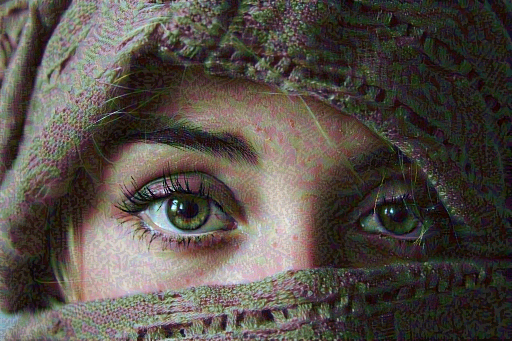

In [ ]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

Since it's working, perform a longer optimization:

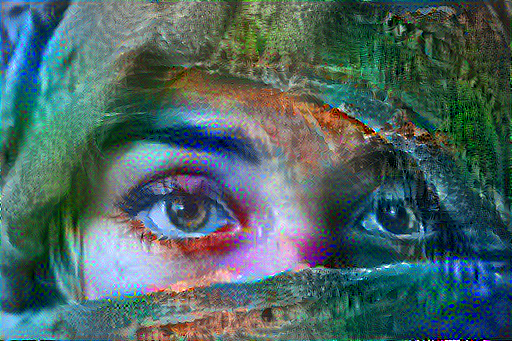

Train step: 1000
Total time: 61.9


In [ ]:
import time
start = time.time()

# setting the epochs and the number of epochs
epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1

    # calling the train step function
    train_step(image)
    print(".", end='', flush=True)

  # display the image in the current epoch after clearing the image from previous epoch
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))

## Total variation loss

One downside to this basic implementation is that it produces a lot of high frequency artifacts. We decrease these using an explicit regularization term on the high frequency components of the image. In style transfer, this is often called the *total variation loss*:

TensorFlow includes a standard implementation to calculate total_variation as given below (to calculate total variation for one ore more images):

In [ ]:
tf.image.total_variation(image).numpy()

array([81476.75], dtype=float32)

## Re-run the optimization

Choose a weight for the `total_variation_loss`:

In [ ]:
total_variation_weight=30

Now include it in the `train_step` function:

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    # using extractor object of SyleContentModel
    # to get style and content representations
    outputs = extractor(image)

    # get the total style and content loss
    loss = style_content_loss(outputs)
    # add the total variation loss to the style and content loss
    loss += total_variation_weight*tf.image.total_variation(image)

  # calculate the gradients using loss obtained
  grad = tape.gradient(loss, image)

  # apply gradients
  opt.apply_gradients([(grad, image)])

  # update the image as per the gradients
  # and clip pixel values to be in 0 and 1 range
  image.assign(clip_0_1(image))

Reinitialize the image-variable and the optimizer:

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
image = tf.Variable(content_image)

And run the optimization:

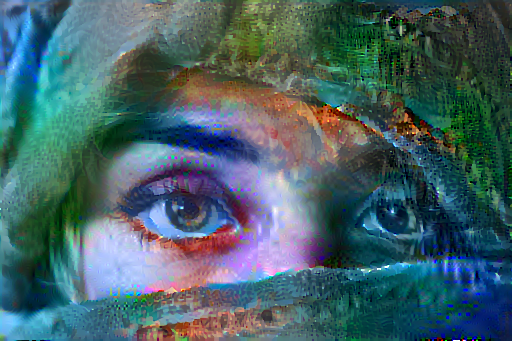

Train step: 1000
Total time: 64.2


In [ ]:
import time
start = time.time()

# setting the epochs and the number of epochs
epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1

    # calling the train step function
    train_step(image)
    print(".", end='', flush=True)
  
  # display the image in the current epoch after clearing the image from previous epoch
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

### Content Image

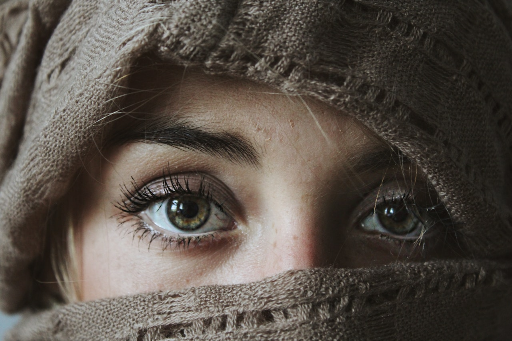

In [ ]:
display.display(tensor_to_image(content_image))

### Style Image

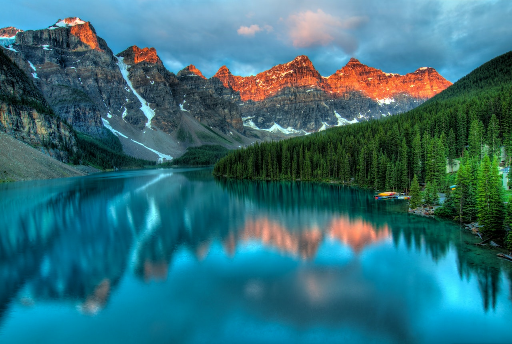

In [ ]:
display.display(tensor_to_image(style_image))

### Generated Image
#### *by combining the style from style image and content from the content image*

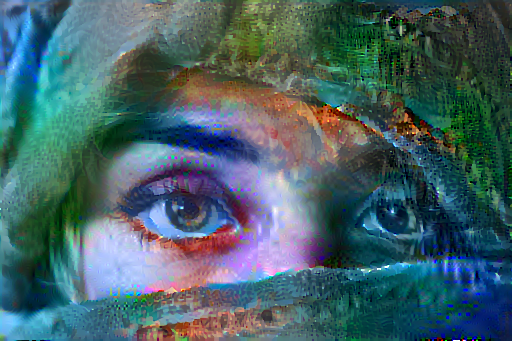

In [ ]:
display.display(tensor_to_image(image))

## Conclusion

We can see that using the transfer learning approach we were successfully able to use a pre-trained neural network VGG-19 for the neural style transfer project. We can observe that using the initial layers for convolution blocks, we can extract style from the style image and using second layer from the last convolution block, we can extract the content image and eventually use the gradient descent to minimize the total loss between the generated image and the content and style image. Initially, the generated image is a clone of the content image and on the training, the network tries to update generated image pixels including style image details.


## References

https://medium.com/@mirzezadeh.elvin/neural-style-transfer-with-deep-vgg-model-26b11ea06b7e

https://towardsdatascience.com/3-ways-to-build-neural-networks-in-tensorflow-with-the-keras-api-80e92d3b5b7e

https://towardsdatascience.com/fast-neural-style-transfer-in-5-minutes-with-tensorflow-hub-magenta-110b60431dcc

https://towardsdatascience.com/tensorflow-and-vgg19-can-help-you-convert-your-photos-into-beautiful-pop-art-pieces-c1abe87e7e01

https://towardsdatascience.com/neural-networks-intuitions-2-dot-product-gram-matrix-and-neural-style-transfer-5d39653e7916

https://www.youtube.com/playlist?list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF

## Literature Review

[Literature Review from princeton.edu](https://www.cs.princeton.edu/courses/archive/spring18/cos598B/public/projects/LiteratureReview/COS598B_spr2018_NeuralStyleTransfer.pdf)

[Literature Review from iopscience.iop.org](https://iopscience.iop.org/article/10.1088/1742-6596/1518/1/012041/pdf)

[Literature Review from ijiset.com](https://ijiset.com/vol8/v8s8/IJISET_V8_I08_38.pdf)
